# Limpieza de texto
### Creación de los dataframe y limpieza de texto

In [70]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)

In [71]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador orizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [72]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [73]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

# Busqueda de titulos

In [115]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.)]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)


# Creacion de dataframe de solo titulos en mayusculas

In [116]:
# Creamos un dataframe para guardar expedientes que solamente tienen titulos en mayusculas
dfTitulosMayusculas = pd.DataFrame(columns=['id', 'expediente'])

# Guardo en dfTitulosMayusculas los expedientes y su indice dentro del dataframe limpio (con todos los expedientes)
expConTitulosMayusculas = []
for id,titulo in  enumerate(dfLimpio):
    if len(titulosMayusculas[id]) > 0:
        expConTitulosMayusculas.append((id,titulo))

dfTitulosMayusculas = pd.DataFrame(expConTitulosMayusculas, columns=['id','expediente'])
#pprint(dfLimpio[8])

### Expedientes con titulos en mayusculas sobre el total de expedientes

In [117]:
print(f'''
Cantidad de expediente que tienen titulos en mayusculas:        {len(dfTitulosMayusculas)}
Cantidad de expedientes que no tienen titulos en mayusculas:    {len(dfLimpio) - len(dfTitulosMayusculas)}  
Total de expedientes: {len(dfLimpio)} 
''')


Cantidad de expediente que tienen titulos en mayusculas:        902
Cantidad de expedientes que no tienen titulos en mayusculas:    2904  
Total de expedientes: 3806 



<module 'matplotlib.pyplot' from 'c:\\Users\\gasto\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

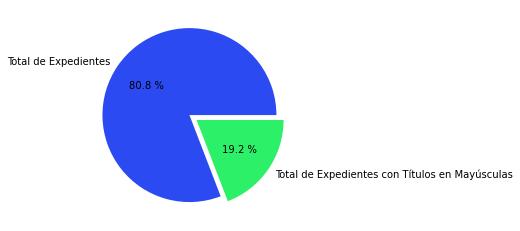

In [118]:
# Creo un grafico de torta
import matplotlib.pyplot as plt


totalExp = len(dfLimpio)
totalExpMayusculas = len(dfTitulosMayusculas)
# Creacion de grafico de torta de la cantidad de expedientes con titulos en mayusculas sobre el total de expedientes.
cantExp = [totalExp, totalExpMayusculas]
nombreTitulos = ['Total de Expedientes', 'Total de Expedientes con Títulos en Mayúsculas']
colores = ['#2C4AF1','#2CF168']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt

## Titulos y ubicacion

In [119]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion=[]

for titulo in titulosMayusculas[1]:
    inicioTitulo = dfLimpio[1].index(titulo)
    palabrasPorTitulo = len(titulo)
    finalTitulo = inicioTitulo + palabrasPorTitulo
    titulosPosicion.append((titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

pprint(titulosPosicion)


#anotar parrafos entre titulos.
#parrafo = texto[inicio:inicio+1]
#mostrar las secciones
#estadisiticas de titulos interdocumentos

[('II). PREAMBULO.', 978, 993, 15),
 ('III). ANTECEDENTES DE INTERES MEDICO PRESENTE EN AUTOS.', 3431, 3486, 55),
 ('IV) EXAMEN DEL PERITO DE OFICIO.', 5035, 5067, 32),
 ('V) CONSIDERACIONES MEDICAS:', 32819, 32846, 27),
 ('VII) CONTESTACION DE PUNTOS PERICIALES.', 43724, 43763, 39),
 ('VIII) BIBLIOGRAFIA.', 45065, 45084, 19),
 ('VII) CONCLUSIONES:', 45833, 45851, 18),
 ('IX). PETITORIO.', 46645, 46660, 15)]


In [ ]:
#pprint(dfLimpio[1][32819:43723])
parrafoConsideraciones = dfLimpio[1][32819:43724]
len(parrafoConsideraciones)
pprint(parrafoConsideraciones)

# PRUEBAS

In [80]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfLimpio.apply(str)
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)
parrafoConsideraciones = limpiarTextoHTML(parrafoConsideraciones)

In [81]:
colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[1]}
        </p>
        <br>
        '''
body = body.replace(parrafoConsideraciones,f'<span style="background-color: #99ccff">{parrafoConsideraciones}</span>')
for titulo in titulosMayusculas[1]:
    body = body.replace(titulo,f'<span style="background-color: #cd5c5c">{titulo}</span>')
with open('parrafos.html','w', encoding="utf-8") as f:
    f.write(body)

In [82]:
# contar las oraciones por parrafo.
# contar oraciones por parrafo.